In [1]:
from visiable_util import *


def prepare_original_cardinality_data(cardinality_data, dataset_name):
    """Prepare original cardinality data for visualization"""
    query_classes = classify_queries()
    plot_data = []
    
    for query_key, query_data in cardinality_data.items():
        # Determine regular query complexity
        reg_complexity = None
        for complexity, queries in query_classes.items():
            if 'regular' in complexity and query_key in queries:
                reg_complexity = complexity
                break
        
        for constraint, values in query_data.items():
            # Determine data constraint complexity
            data_complexity = None
            if constraint in query_classes['simple_data']:
                data_complexity = 'simple_data'
            elif constraint in query_classes['complex_data']:
                data_complexity = 'complex_data'
            
            for value in values:
                plot_data.append({
                    'dataset': dataset_name,
                    'query': query_key,
                    'constraint': constraint,
                    'cardinality': value,
                    'regular_complexity': reg_complexity,
                    'data_complexity': data_complexity
                })
    
    return pd.DataFrame(plot_data)

def plot_violin_distributions(all_cardinality_data):
    """Create violin plots showing distribution of original cardinality data with log scale"""
    
    os.makedirs('figure/violin_distributions', exist_ok=True)
    
    # Combine all datasets
    all_data = []
    for dataset_name, df in all_cardinality_data.items():
        all_data.append(df)
    
    merged_df = pd.concat(all_data, ignore_index=True)
    
    # Get unique datasets for ordering
    datasets = merged_df['dataset'].unique()
    
    # Check data range
    min_val = merged_df['cardinality'].min()
    max_val = merged_df['cardinality'].max()
    print(f"Data range: {min_val} to {max_val}")
    
    # 1. Data constraint violin plot (one figure)
    plot_data_constraint_violin(merged_df, datasets)
    
    # 2. Regular constraint violin plot (one figure)
    plot_regular_constraint_violin(merged_df, datasets)
    
    return merged_df

def plot_data_constraint_violin(df, datasets):
    """Single violin plot for data constraints (simple vs complex) with log scale"""
    
    # Filter for data queries only
    data_df = df[df['data_complexity'].notnull()].copy()
    
    if len(data_df) == 0:
        print("No data for data constraint violin plot")
        return
    
    fig, ax = plt.subplots(figsize=(16, 10))

    # Create boxen plot with adjusted parameters for log scale
    sns.boxenplot(data=data_df, x='dataset', y='cardinality', hue='data_complexity',
                   ax=ax,palette=DATA_COLOR, order=datasets, showfliers=True)
    
    # Set logarithmic y-scale
    ax.set_yscale('log')
    
    # Set titles and labels
    # ax.set_title('Cardinality Distribution: Data Constraints\n(Simple D1-D2 vs Complex D3-D5) - Log Scale', 
    #             fontsize=16, pad=20)
    ax.set_xlabel('Dataset', fontsize=40)
    ax.set_ylabel('Oracle Query Counts', fontsize=40)
    ax.tick_params(axis='x', labelsize=40)
    ax.tick_params(axis='y', labelsize=40)
    # Improve legend
    handles, labels = ax.get_legend_handles_labels()
    new_labels = ['Simple Data', 'Complex Data']
    ax.legend(handles, new_labels, fontsize=40, loc='upper center', ncol=2,  bbox_to_anchor=(0.5, 1.15))
    
    # Add grid
    ax.grid(True, alpha=0.3, axis='y')
    

    
    plt.tight_layout()
    
    # Save figure
    filename = 'figure/violin_distributions/data_constraint_violin_plot_log.pdf'
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close()
    
    print("Created data constraint violin plot with log scale")

def plot_regular_constraint_violin(df, datasets):
    """Single violin plot for regular constraints (simple, medium, complex) with log scale"""
    
    # Filter for regular queries only
    regular_df = df[df['regular_complexity'].notnull()].copy()
    
    if len(regular_df) == 0:
        print("No data for regular constraint violin plot")
        return
    
    fig, ax = plt.subplots(figsize=(21, 12))
    
    # Create violin plot with adjusted parameters for log scale
    sns.boxenplot(data=regular_df, x='dataset', y='cardinality', hue='regular_complexity',
                   ax=ax,  palette=REGULAR_COLOR, order=datasets, showfliers=True)
    
    # Set logarithmic y-scale
    ax.set_yscale('log')
    
    # Set titles and labels
    # ax.set_title('Cardinality Distribution: Regular Query Constraints\n(Simple, Medium, Complex Queries) - Log Scale', 
    #             fontsize=16, pad=20)
    ax.set_xlabel('Dataset', fontsize=45)
    ax.set_ylabel('Oracle Query Counts', fontsize=45)
    ax.tick_params(axis='x', labelsize=45)
    ax.tick_params(axis='y', labelsize=45)

    # Improve legend
    handles, labels = ax.get_legend_handles_labels()
    new_labels = ['Frequently-used', 
                 'Occasionally-used', 
                 'Rarely-used']
    ax.legend(handles, new_labels,  fontsize=45, loc='upper right', ncol=1 )

    # Add grid
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add data range information
    # min_val = regular_df['cardinality'].min()
    # max_val = regular_df['cardinality'].max()
    # ax.text(0.02, 0.98, f'Data range: {min_val} - {max_val}', 
    #        transform=ax.transAxes, fontsize=10,
    #        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    
    # Save figure
    filename = 'figure/violin_distributions/regular_constraint_violin_plot_log.pdf'
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close()
    
    print("Created regular constraint violin plot with log scale")

def analyze_cardinality_distributions(cardinality_paths):
    """
    Main function to analyze cardinality distributions with violin plots using log scale
    """
    
    all_cardinality_data = {}
    
    print("Loading and processing data...")
    
    # Load cardinality data only
    for dataset_name, path in cardinality_paths.items():
        print(f"  Loading cardinality data for {dataset_name}...")
        cardinality_data = slice_small_log(path)
        cardinality_df = prepare_original_cardinality_data(cardinality_data, dataset_name)
        all_cardinality_data[dataset_name] = cardinality_df
    
    # Create violin plots for cardinality distribution with log scale
    print("Creating violin plots with logarithmic scale...")
    merged_cardinality_df = plot_violin_distributions(all_cardinality_data)
    
    print("\nAnalysis complete!")
    print(f"Total cardinality data points: {len(merged_cardinality_df):,}")
    print(f"Number of datasets: {len(all_cardinality_data)}")
    print(f"Cardinality range: {merged_cardinality_df['cardinality'].min()} to {merged_cardinality_df['cardinality'].max()}")
    
    # Print summary
    print("\nCreated the following files:")
    print("- 1 data constraint violin plot with log scale (showing D1-D2 vs D3-D5 across all datasets)")
    print("- 1 regular constraint violin plot with log scale (showing simple/medium/complex queries across all datasets)")

analyze_cardinality_distributions(Z3_LOG_PATHS)

Loading and processing data...
  Loading cardinality data for L1...
  Loading cardinality data for L0...
  Loading cardinality data for PO...
  Loading cardinality data for TE...
  Loading cardinality data for IL...
  Loading cardinality data for IP...
Creating violin plots with logarithmic scale...
Data range: 0 to 27789
Created data constraint violin plot with log scale
Created regular constraint violin plot with log scale

Analysis complete!
Total cardinality data points: 36,000
Number of datasets: 6
Cardinality range: 0 to 27789

Created the following files:
- 1 data constraint violin plot with log scale (showing D1-D2 vs D3-D5 across all datasets)
- 1 regular constraint violin plot with log scale (showing simple/medium/complex queries across all datasets)


In [4]:
from visiable_util import *


def prepare_original_cardinality_data(cardinality_data, dataset_name):
    """Prepare original cardinality data for visualization"""
    query_classes = classify_queries()
    plot_data = []
    
    for query_key, query_data in cardinality_data.items():
        # Determine regular query complexity
        reg_complexity = None
        for complexity, queries in query_classes.items():
            if 'regular' in complexity and query_key in queries:
                reg_complexity = complexity
                break
        
        for constraint, values in query_data.items():
            # Determine data constraint complexity
            data_complexity = None
            if constraint in query_classes['simple_data']:
                data_complexity = 'simple_data'
            elif constraint in query_classes['complex_data']:
                data_complexity = 'complex_data'
            
            for value in values:
                plot_data.append({
                    'dataset': dataset_name,
                    'query': query_key,
                    'constraint': constraint,
                    'cardinality': value,
                    'regular_complexity': reg_complexity,
                    'data_complexity': data_complexity
                })
    
    return pd.DataFrame(plot_data)

def plot_violin_distributions(all_cardinality_data):
    """Create violin plots showing distribution of original cardinality data with log scale"""
    
    os.makedirs('figure/violin_distributions', exist_ok=True)
    
    # Combine all datasets
    all_data = []
    for dataset_name, df in all_cardinality_data.items():
        all_data.append(df)
    
    merged_df = pd.concat(all_data, ignore_index=True)
    
    # Get unique datasets for ordering
    datasets = merged_df['dataset'].unique()
    
    # Check data range
    min_val = merged_df['cardinality'].min()
    max_val = merged_df['cardinality'].max()
    print(f"Data range: {min_val} to {max_val}")
    
    # 1. Data constraint violin plot (one figure)
    plot_data_constraint_violin(merged_df, datasets)
    
    # 2. Regular constraint violin plot (one figure)
    plot_regular_constraint_violin(merged_df, datasets)
    
    return merged_df

def plot_data_constraint_violin(df, datasets):
    """Single violin plot for data constraints (simple vs complex) with log scale"""
    
    # Filter for data queries only
    data_df = df[df['data_complexity'].notnull()].copy()
    
    if len(data_df) == 0:
        print("No data for data constraint violin plot")
        return
    
    fig, ax = plt.subplots(figsize=(16, 10))
    # Create box plot with adjusted parameters for log scale
    sns.boxenplot(data=data_df, x='dataset', y='cardinality', hue='data_complexity', showfliers=True,
                   ax=ax, palette=DATA_COLOR, order=datasets
                   )
    
    # Set logarithmic y-scale
    ax.set_yscale('log')
    
    # Set titles and labels
    # ax.set_title('Cardinality Distribution: Data Constraints\n(Simple D1-D2 vs Complex D3-D5) - Log Scale', 
    #             fontsize=16, pad=20)
    ax.set_xlabel('Dataset', fontsize=40)
    ax.set_ylabel('Time(ms)', fontsize=40)
    ax.tick_params(axis='x', labelsize=40)
    ax.tick_params(axis='y', labelsize=40)
    # Improve legend
    handles, labels = ax.get_legend_handles_labels()
    new_labels = ['Simple Data', 'Complex Data']
    ax.legend(handles, new_labels, fontsize=40, loc='upper center', ncol=2,  bbox_to_anchor=(0.5, 1.2))
    
    # Add grid
    ax.grid(True, alpha=0.3, axis='y')
    

    
    plt.tight_layout()
    
    # Save figure
    filename = 'figure/box_distributions/data_constraint_box_plot_log.pdf'
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close()

    print("Created data constraint box plot with log scale")

def plot_regular_constraint_violin(df, datasets):
    """Single violin plot for regular constraints (simple, medium, complex) with log scale"""
    
    # Filter for regular queries only
    regular_df = df[df['regular_complexity'].notnull()].copy()
    
    if len(regular_df) == 0:
        print("No data for regular constraint violin plot")
        return
    
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Create violin plot with adjusted parameters for log scale
    sns.boxenplot(data=regular_df, x='dataset', y='cardinality', hue='regular_complexity', showfliers=True,
                   ax=ax, palette=REGULAR_COLOR, order=datasets
                   )
    
    # Set logarithmic y-scale
    ax.set_yscale('log')
    
    # Set titles and labels
    # ax.set_title('Cardinality Distribution: Regular Query Constraints\n(Simple, Medium, Complex Queries) - Log Scale', 
    #             fontsize=16, pad=20)
    ax.set_xlabel('Dataset', fontsize=50)
    ax.set_ylabel('Time(ms)', fontsize=50)
    ax.tick_params(axis='x', labelsize=50)
    ax.tick_params(axis='y', labelsize=50)

    # Improve legend
    handles, labels = ax.get_legend_handles_labels()
    new_labels = ['Frequently-used', 
                 'Occasionally-used', 
                 'Rarely-used']
    ax.legend(handles, new_labels,  fontsize=50, loc='upper left', ncol=1,bbox_to_anchor=(-0.01, 1.02))

    # Add grid
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add data range information
    # min_val = regular_df['cardinality'].min()
    # max_val = regular_df['cardinality'].max()
    # ax.text(0.02, 0.98, f'Data range: {min_val} - {max_val}', 
    #        transform=ax.transAxes, fontsize=10,
    #        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    
    # Save figure
    filename = 'figure/box_distributions/regular_constraint_box_plot_log.pdf'
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close()

    print("Created regular constraint box plot with log scale")

def analyze_runtime_distributions(cardinality_paths):
    """
    Main function to analyze cardinality distributions with violin plots using log scale
    """
    
    all_cardinality_data = {}
    
    print("Loading and processing data...")
    
    # Load cardinality data only
    for dataset_name, path in cardinality_paths.items():
        print(f"  Loading cardinality data for {dataset_name}...")
        cardinality_data = load_running_time_data(path, dataset_name)
        cardinality_df = prepare_original_cardinality_data(cardinality_data, dataset_name)
        all_cardinality_data[dataset_name] = cardinality_df
    
    # Create violin plots for cardinality distribution with log scale
    print("Creating violin plots with logarithmic scale...")
    merged_cardinality_df = plot_violin_distributions(all_cardinality_data)
    
    print("\nAnalysis complete!")
    print(f"Total cardinality data points: {len(merged_cardinality_df):,}")
    print(f"Number of datasets: {len(all_cardinality_data)}")
    print(f"Cardinality range: {merged_cardinality_df['cardinality'].min()} to {merged_cardinality_df['cardinality'].max()}")
    
    # Print summary
    print("\nCreated the following files:")
    print("- 1 data constraint violin plot with log scale (showing D1-D2 vs D3-D5 across all datasets)")
    print("- 1 regular constraint violin plot with log scale (showing simple/medium/complex queries across all datasets)")

analyze_runtime_distributions(OPTIMIZED_PATHS)

Loading and processing data...
  Loading cardinality data for L1...
  Loading cardinality data for L0...
  Loading cardinality data for PO...
  Loading cardinality data for TE...
  Loading cardinality data for IL...
  Loading cardinality data for IP...
Creating violin plots with logarithmic scale...
Data range: 0.441178 to 14976.024306
Created data constraint box plot with log scale
Created regular constraint box plot with log scale

Analysis complete!
Total cardinality data points: 36,000
Number of datasets: 6
Cardinality range: 0.441178 to 14976.024306

Created the following files:
- 1 data constraint violin plot with log scale (showing D1-D2 vs D3-D5 across all datasets)
- 1 regular constraint violin plot with log scale (showing simple/medium/complex queries across all datasets)


In [5]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

def plot_time_distribution_by_constraint(path, path2, ds, name1="Optimized", name2="Naive", timeout=10):
    """
    Plot time distribution by data constraint complexity using box plots
    - Simple: D1, D2
    - Complex: D3, D4, D5
    """
    # Load both datasets
    with open(path, "rb+") as f:
        data1 = pickle.loads(f.read())
    with open(path2, "rb+") as f:
        data2 = pickle.loads(f.read())
    
    # Process both datasets
    data_groups = []
    for dataset, name in [(data1, name1), (data2, name2)]:
        for i in range(12):  # Q1-Q12
            id = 0
            for dtype in ["RPQ", "D1", "D2", "D3", "D4", "D5"]:
                if id == 0:  # Skip RPQ
                    id += 1
                    continue
                data = list(map(lambda x: x, dataset[i*6 + id][2]))
                id += 1
                data_groups.append((f"Q{i+1}", dtype, name, data))

    # Prepare data
    plot_data = []
    for group, dtype, dataset_name, values in data_groups:
        for value in values:
            plot_data.append({
                'Query': group,
                'Data Constraint': dtype,
                'Dataset': dataset_name,
                'Time': value,
                'IsTimeout': (value / 1000) > timeout
            })
    
    df = pd.DataFrame(plot_data)
    
    # Classify data constraints
    def classify_constraint(dtype):
        if dtype in ['D1', 'D2']:
            return 'Simple'
        elif dtype in ['D3', 'D4', 'D5']:
            return 'Complex'
        return 'Other'
    
    df['Constraint_Complexity'] = df['Data Constraint'].apply(classify_constraint)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(16, 12))
    sns.set_style("whitegrid")
    
#  Create violin plot with adjusted parameters
    violin = sns.boxenplot(data=df, x='Constraint_Complexity', y='Time', 
                           hue='Dataset', ax=ax,
                           palette=['white', 'grey'], showfliers=True 
                           )        # Width of violins
    
    # boxplot = sns.boxplot(data=df, x='Constraint_Complexity', y='Time', 
    #                      hue='Dataset', ax=ax, showfliers=False,
    #                      palette=['white', 'grey'])    
    
    # Add individual data points for thin violins
    # sns.stripplot(data=df, x='Constraint_Complexity', y='Time', 
    #               hue='Dataset', ax=ax, dodge=True, jitter=True, 
    #               alpha=0.4, size=2, palette=['black', 'black'])
    # # Add timeout threshold line
    # timeout_ms = timeout * 1000
    # ax.axhline(y=timeout_ms, color='red', linestyle='--', linewidth=2, 
    #           alpha=0.8, label=f'Timeout Threshold ({timeout}s)')
    
    # Customize plot
    ax.set_xlabel('', fontsize=16, fontweight='bold')
    ax.set_ylabel('Time (ms)', fontsize=70, fontweight='bold')
    ax.tick_params(axis='y', labelsize=75)
    # ax.set_title(f'Time Distribution by Data Constraint Complexity\nDataset: {ds}', 
                #  fontsize=18, fontweight='bold')
    ax.set_xticklabels(['Simple', 'Complex'], fontsize=75)

    # Use logarithmic scale if appropriate
    max_time = df['Time'].max()
    min_nonzero = df[df['Time'] > 0]['Time'].min()
    
    if max_time > 0 and min_nonzero > 0 and max_time / min_nonzero > 100:
        ax.set_yscale('log')
        ax.set_ylabel('Time (ms)', fontsize=70, fontweight='bold')
        # ax.set_title(f'Time Distribution by Data Constraint Complexity (log scale)\nDataset: {ds}', 
                    #  fontsize=18, fontweight='bold')
    
  
    legend_elements = [
                # Scatter point elements
        # Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgrey', 
        #        markeredgecolor='black', markersize=40, linestyle='None'),
        # Line2D([0], [0], marker='o', color='w', markerfacecolor='black', 
        #        markeredgecolor='black', markersize=40, linestyle='None'),
        # Box plot elements
        Patch(facecolor='white', edgecolor='black', label=name1),
        Patch(facecolor='grey', edgecolor='black', label=name2),
        
            ]
    
    ax.legend(handles=legend_elements, loc='upper center', 
              bbox_to_anchor=(0.5, 1.3), ncol=2, fontsize=75,
              frameon=True, fancybox=True, shadow=True)    
    # Adjust layout
    # plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    
    plt.savefig(f'figure/{ds}-time-distribution-by-constraint.pdf', 
                format='pdf', dpi=1200, bbox_inches='tight')
    plt.show()
    
    return df



/tmp/ipykernel_29287/199703335.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Simple', 'Complex'], fontsize=75)


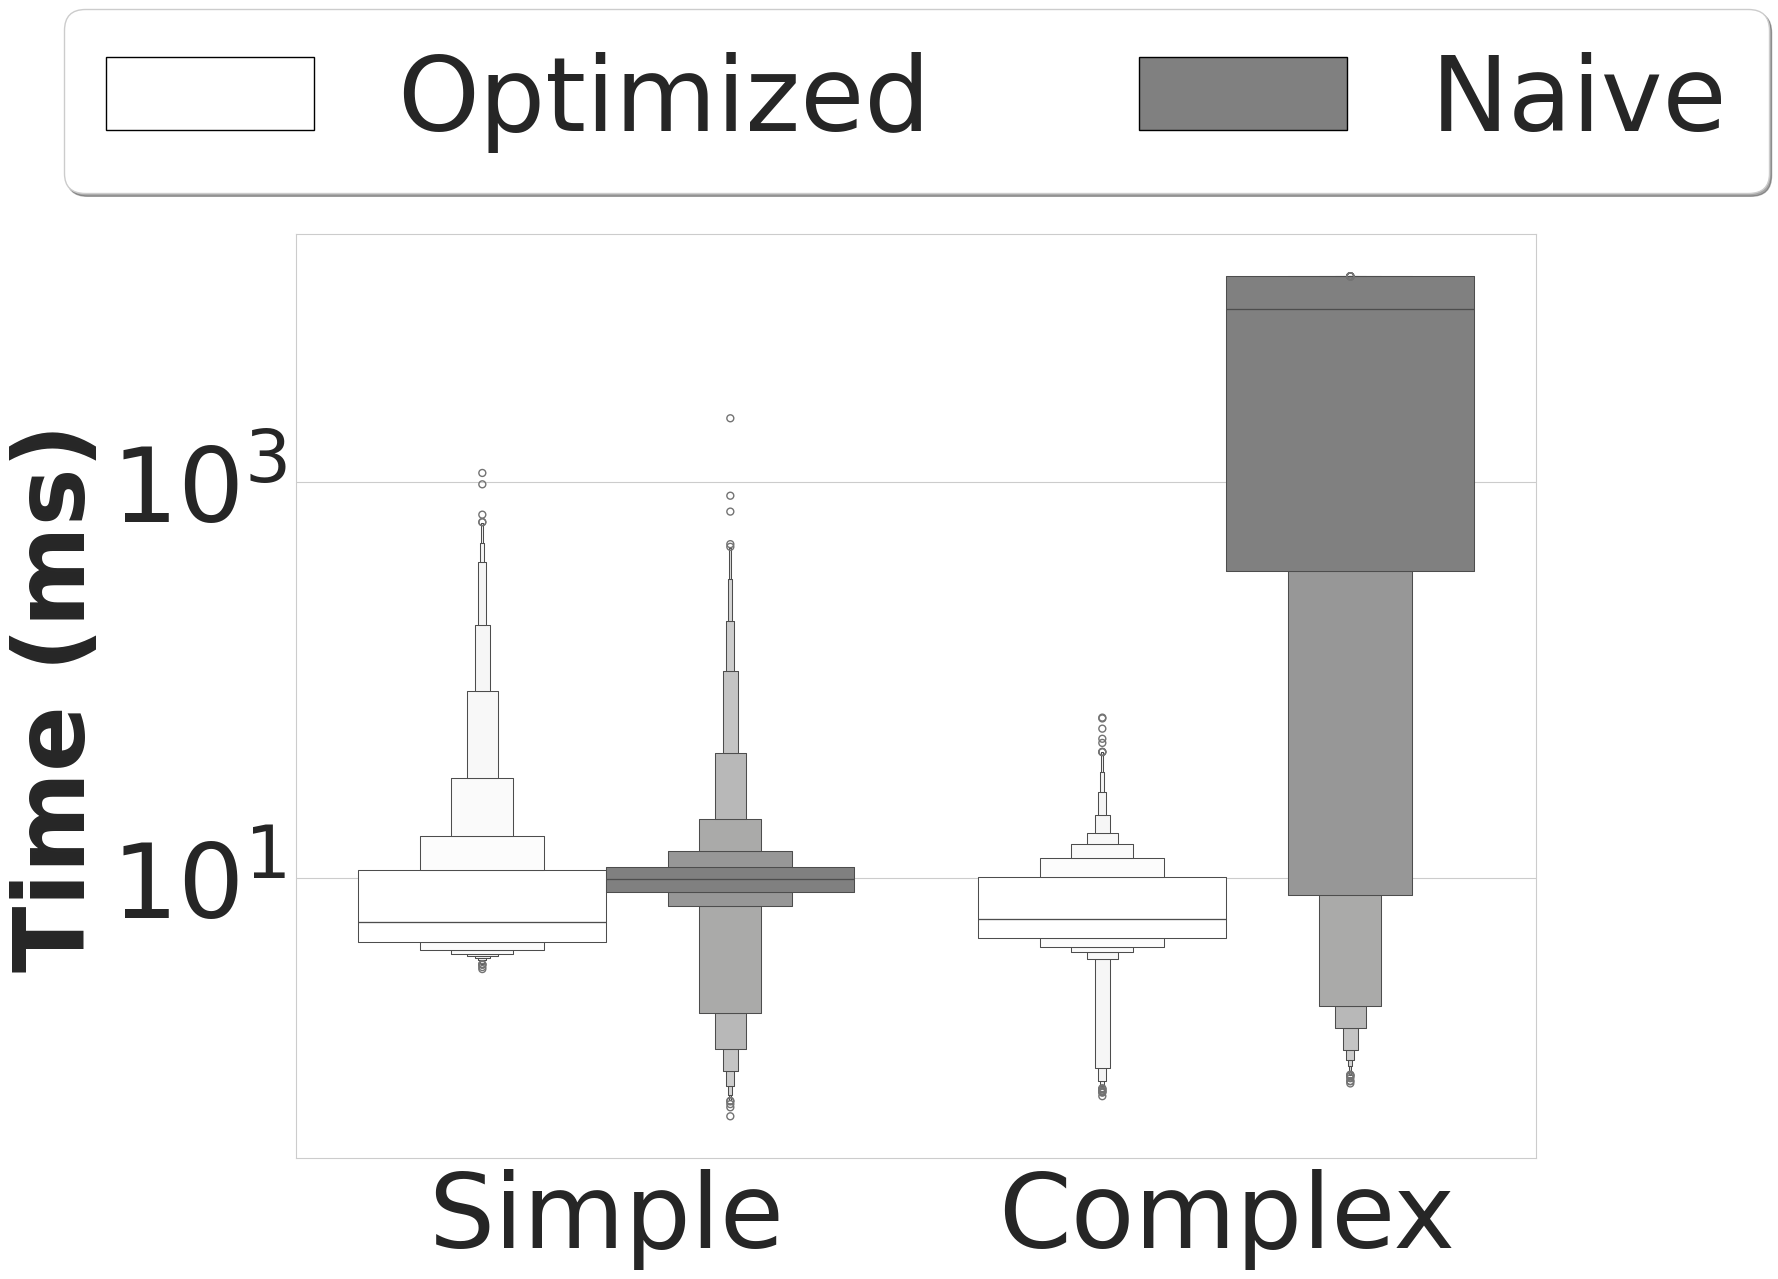

/tmp/ipykernel_29287/199703335.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Simple', 'Complex'], fontsize=75)


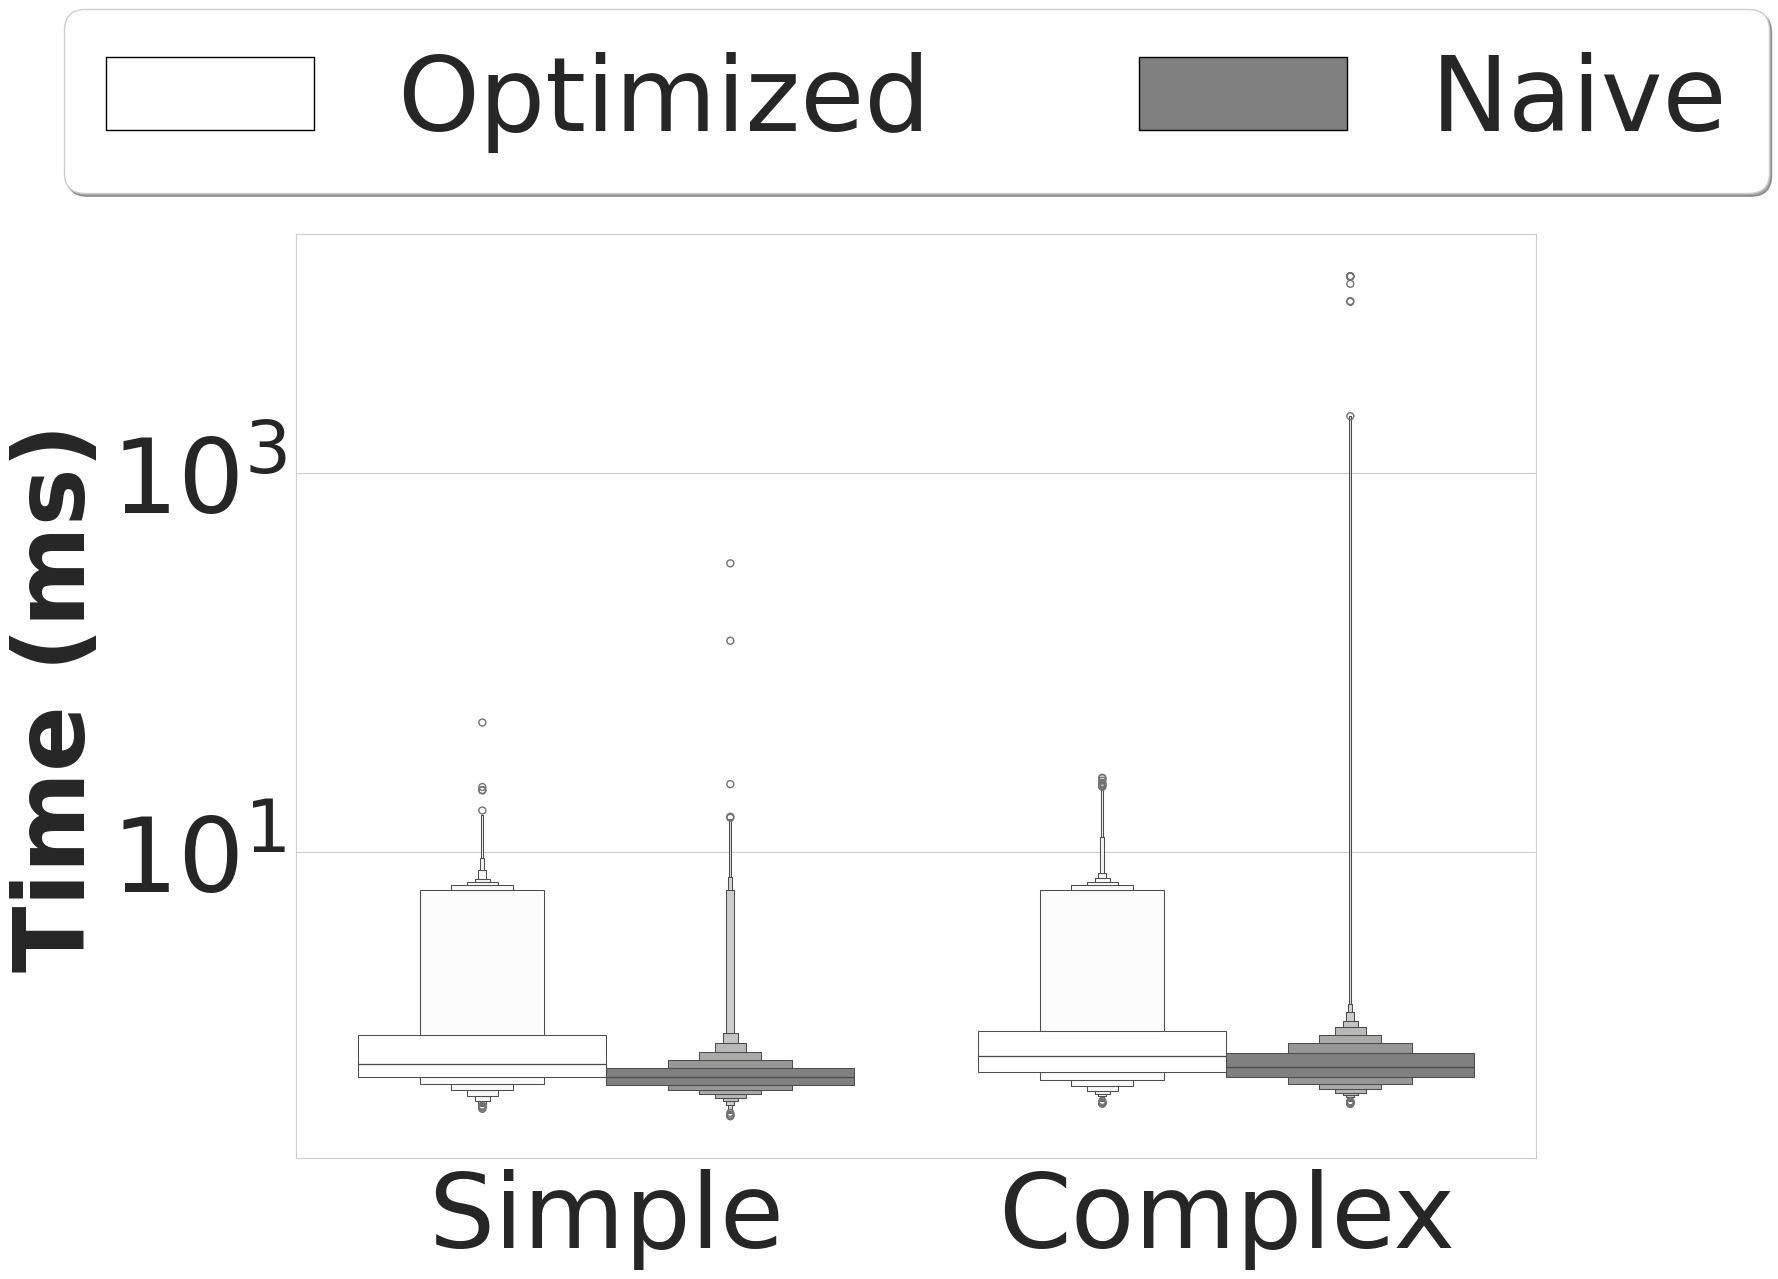

/tmp/ipykernel_29287/199703335.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Simple', 'Complex'], fontsize=75)


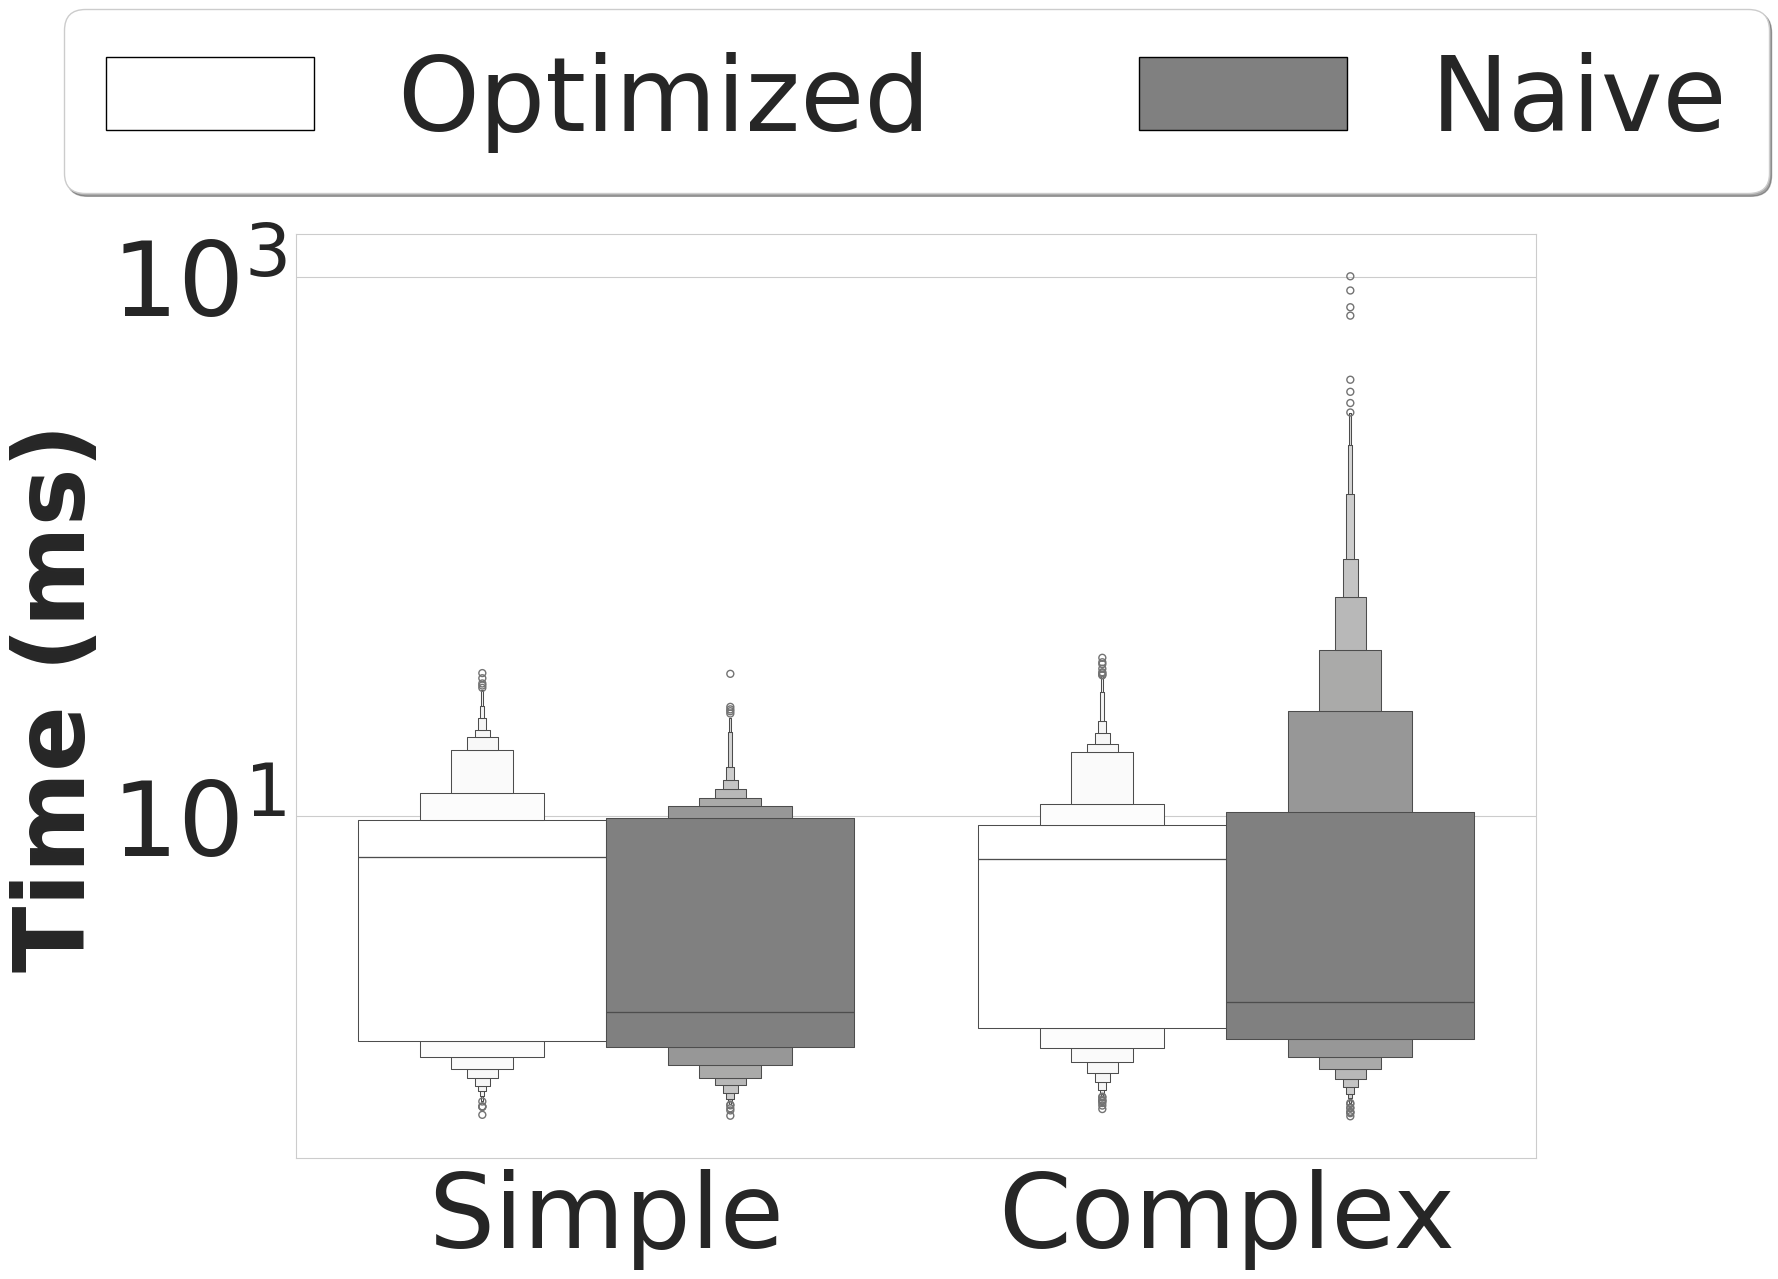

/tmp/ipykernel_29287/199703335.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Simple', 'Complex'], fontsize=75)


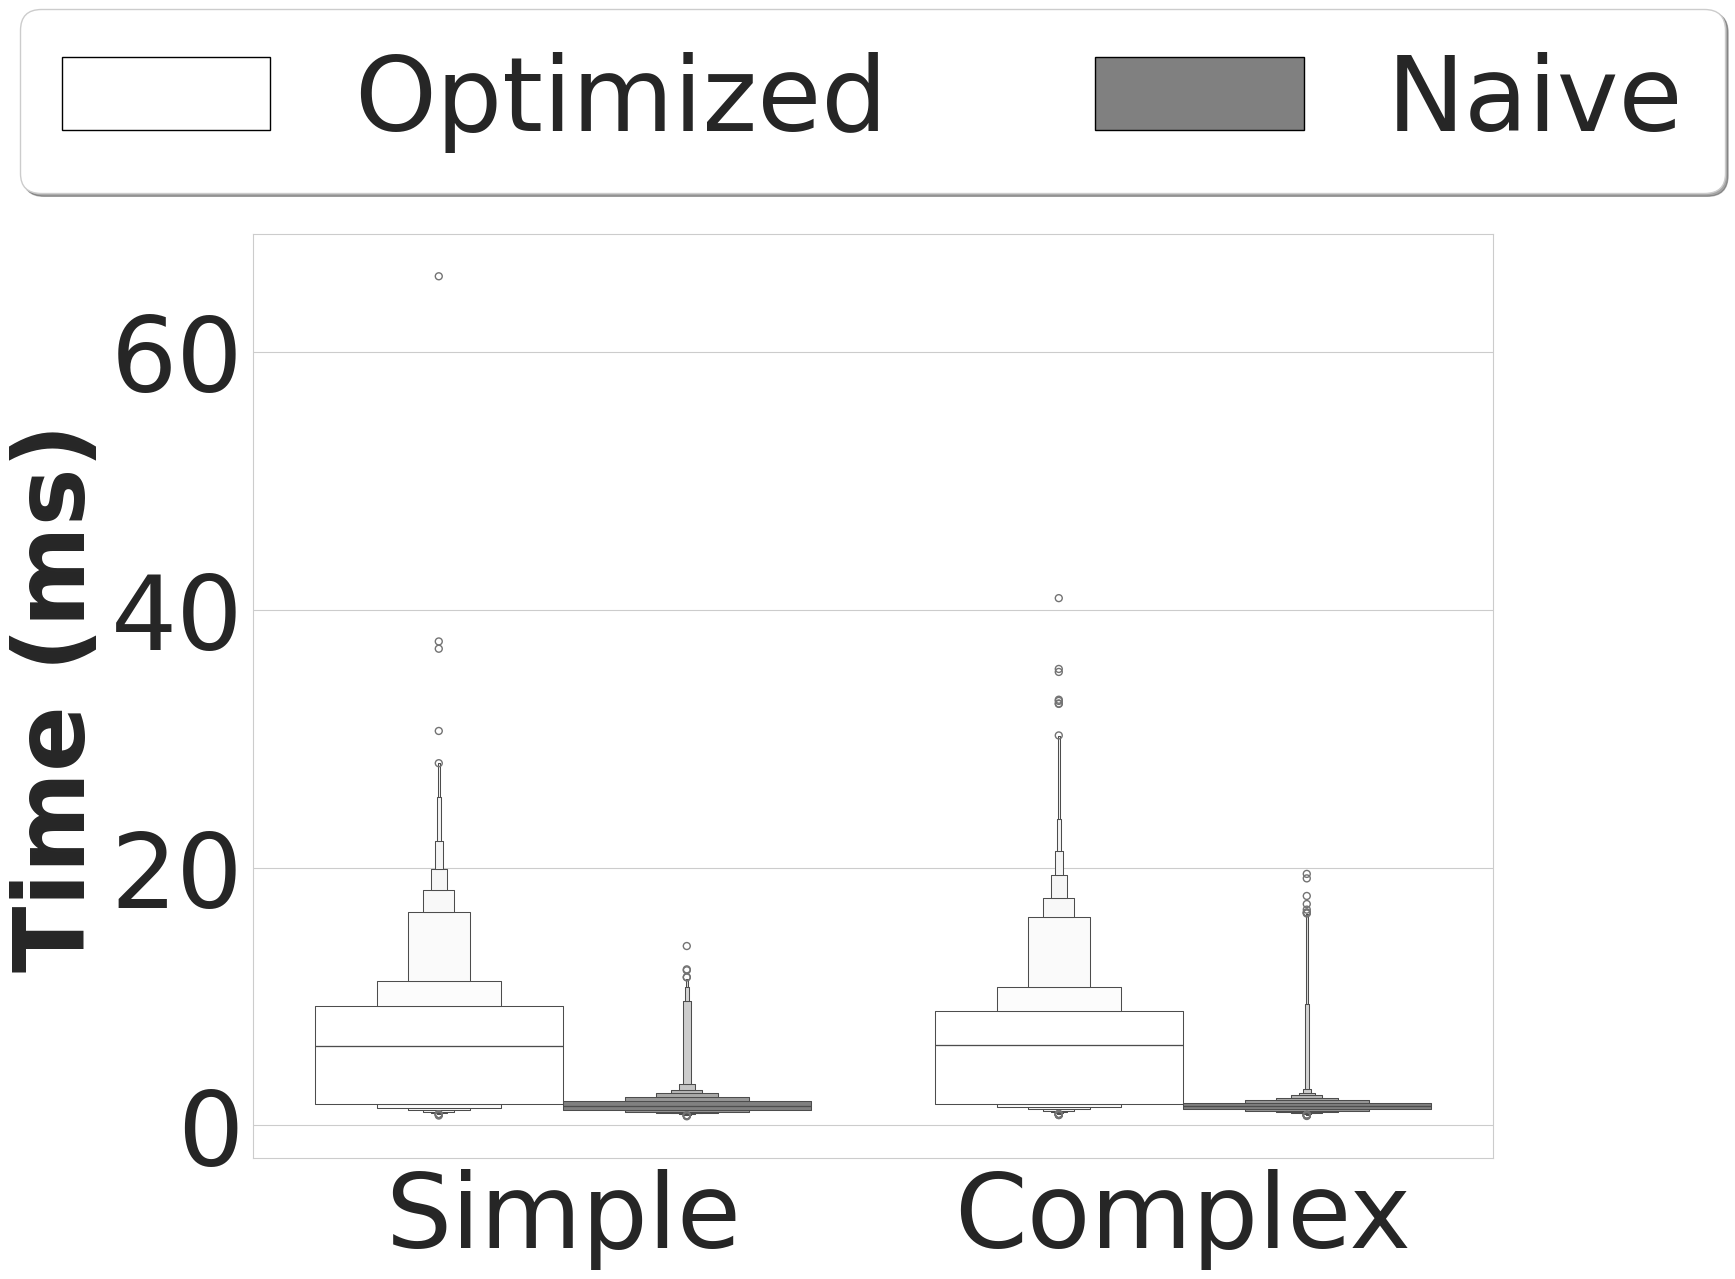

/tmp/ipykernel_29287/199703335.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Simple', 'Complex'], fontsize=75)


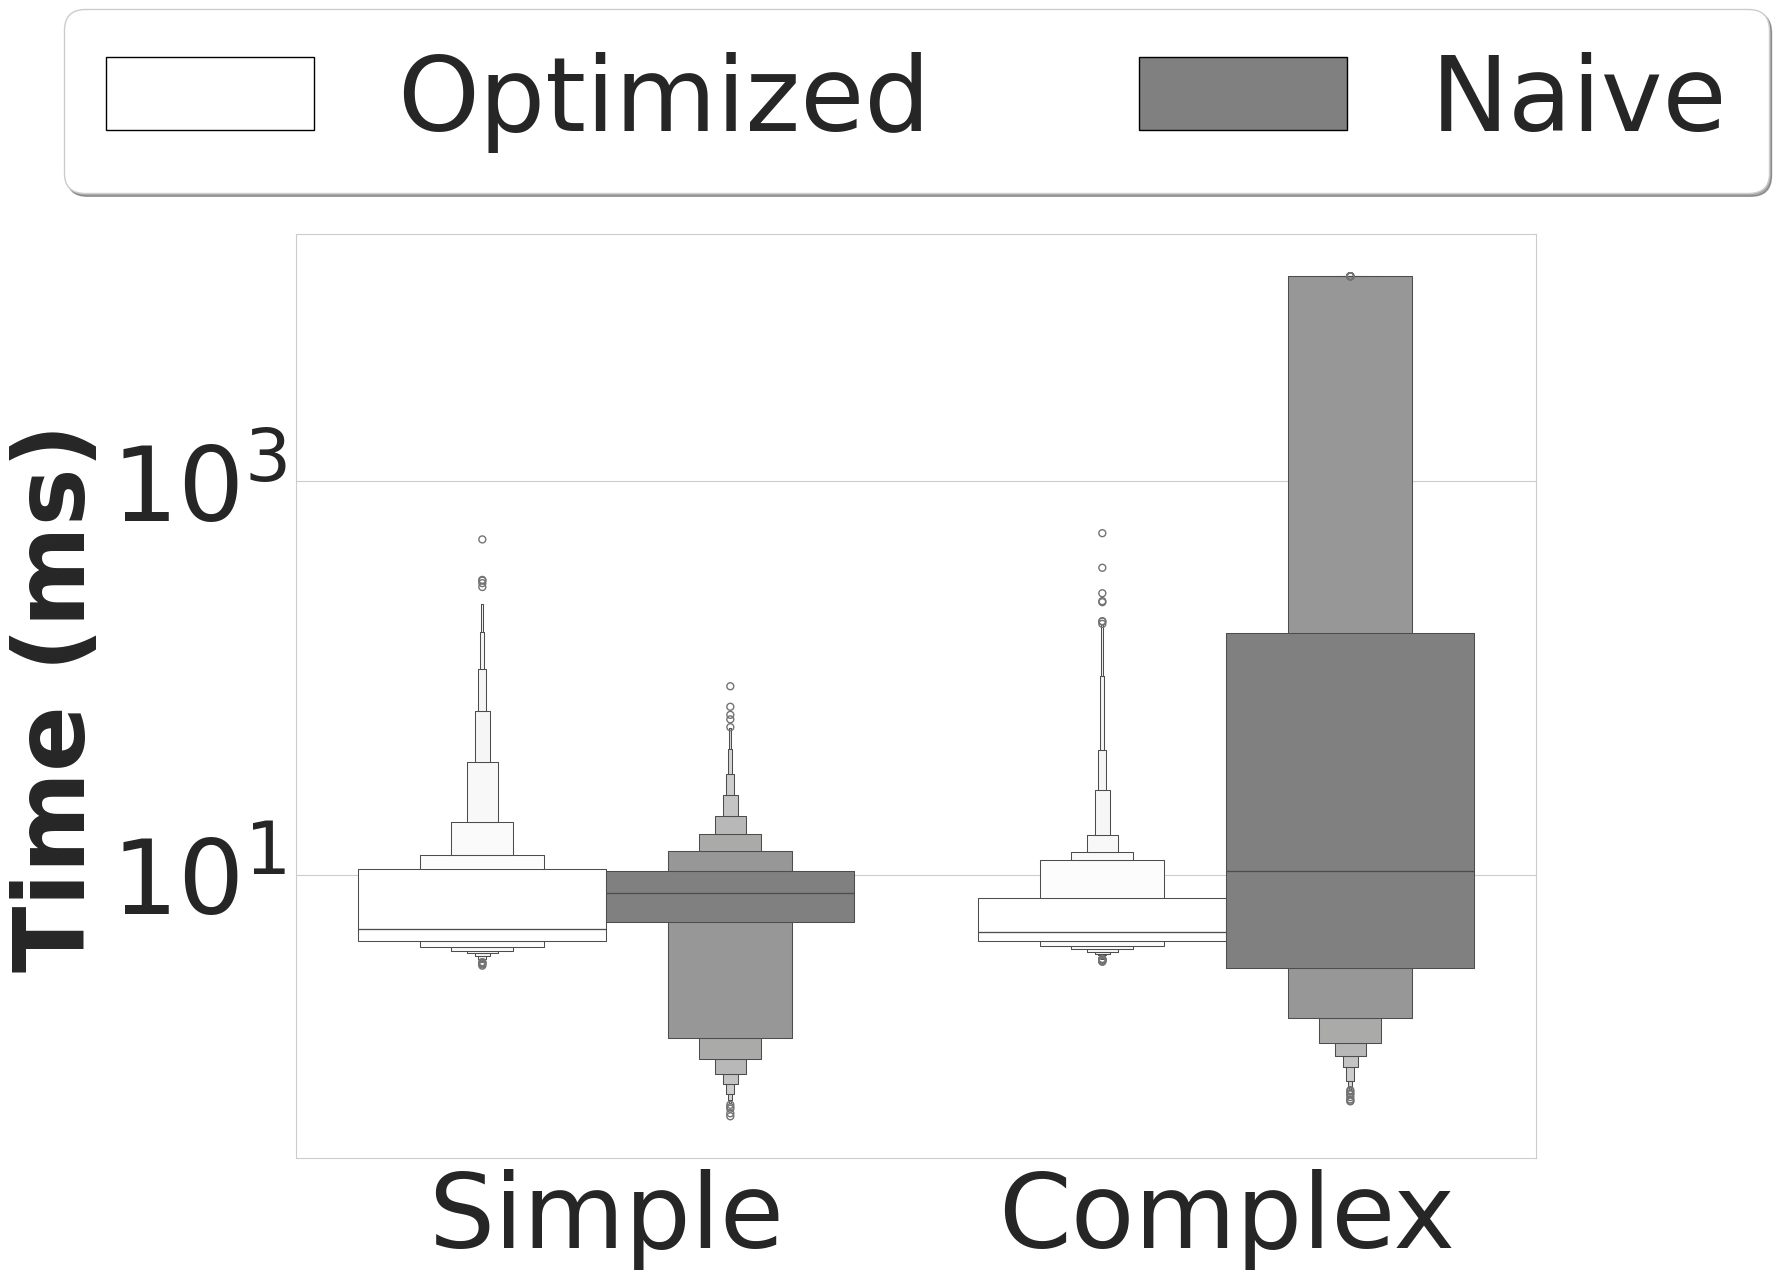

/tmp/ipykernel_29287/199703335.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Simple', 'Complex'], fontsize=75)


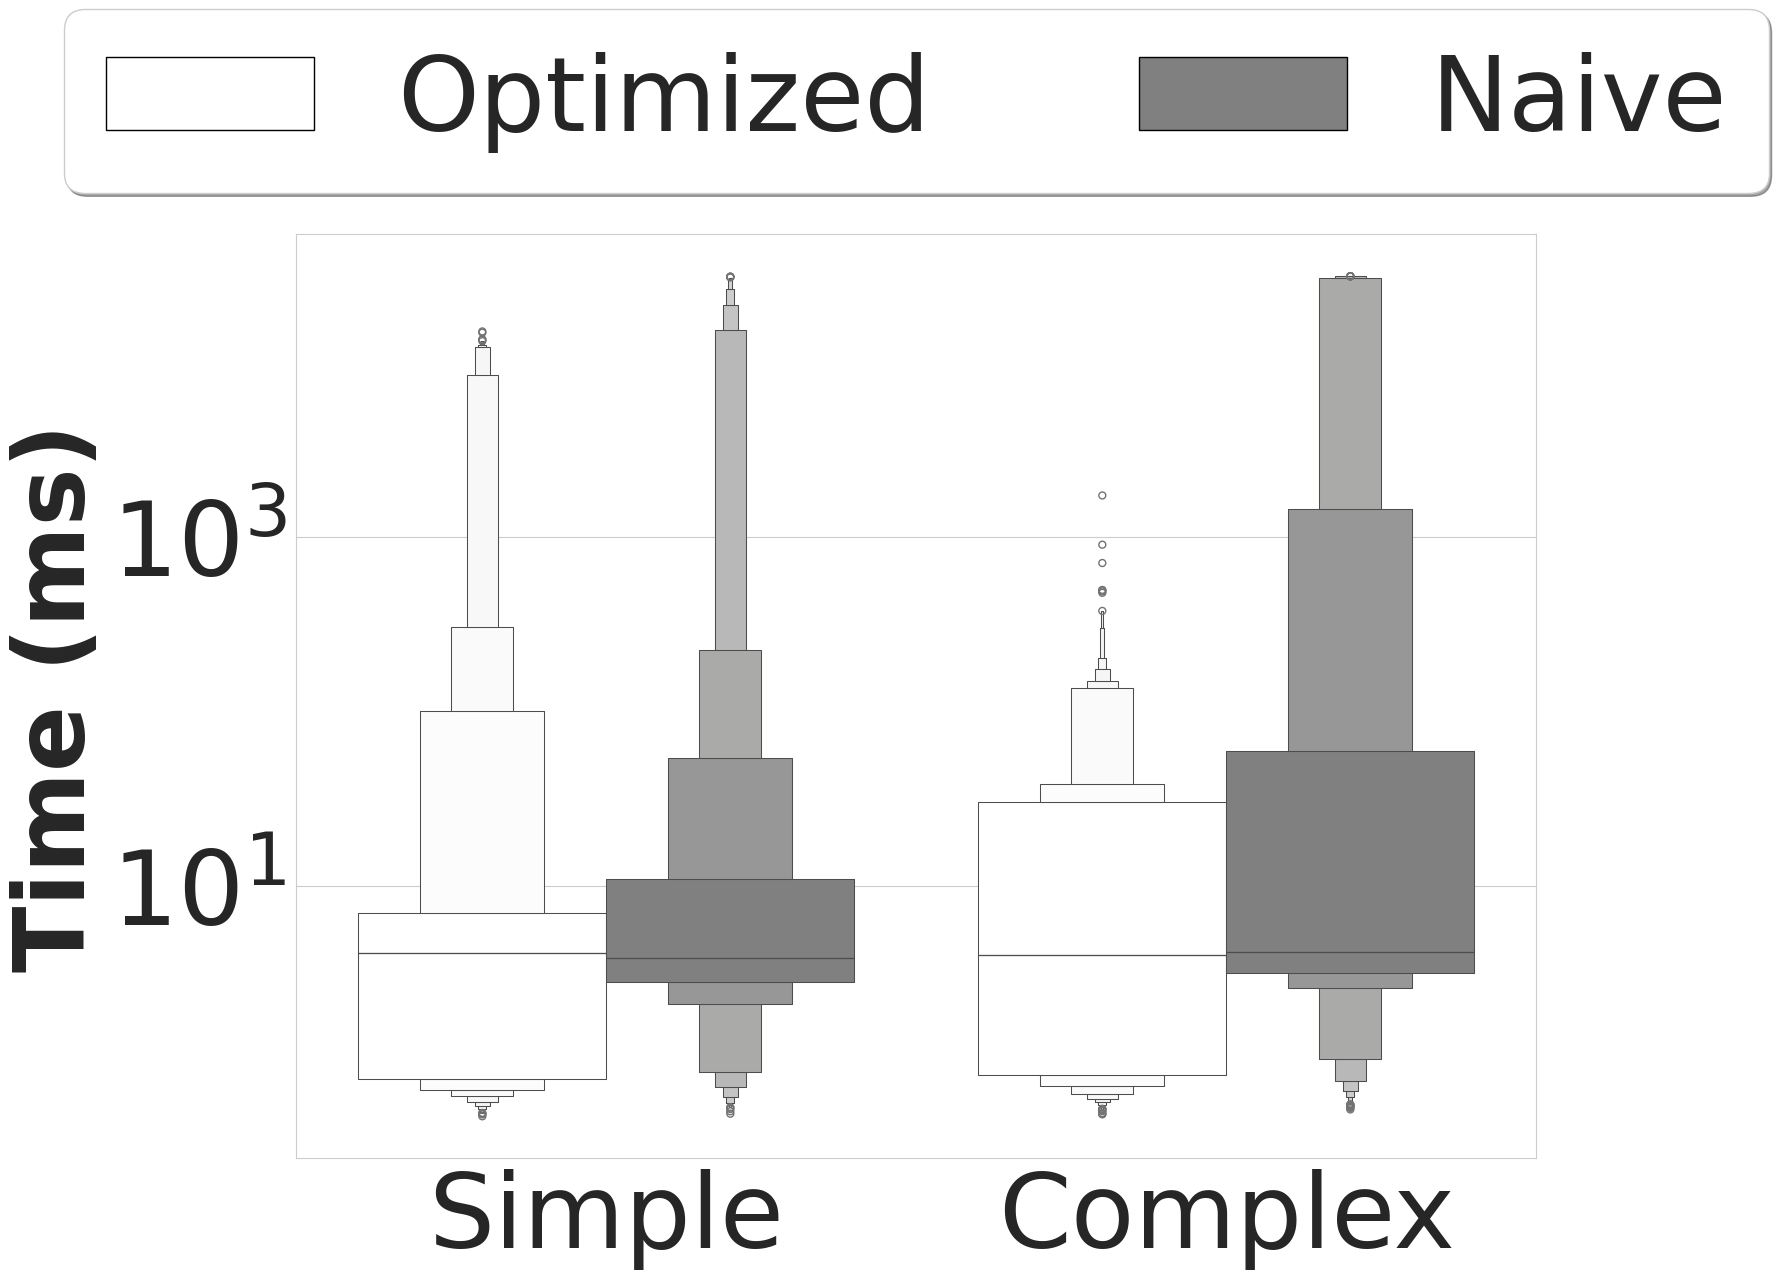

,Query,Data Constraint,Dataset,Time,IsTimeout,Constraint_Complexity
0,Q1,D1,Optimized,34.395211,False,Simple
1,Q1,D1,Optimized,6.278048,False,Simple
2,Q1,D1,Optimized,15.541130,False,Simple
3,Q1,D1,Optimized,5.867249,False,Simple
4,Q1,D1,Optimized,5.896984,False,Simple
...,...,...,...,...,...,...
11995,Q12,D5,Naive,4.356485,False,Complex
11996,Q12,D5,Naive,31002.653145,True,Complex
11997,Q12,D5,Naive,4.177688,False,Complex
11998,Q12,D5,Naive,30999.111541,True,Complex


In [9]:
plot_time_distribution_by_constraint("case-study/ldbc10/ldbc10_statistic.pkl", "case-study/ldbc10-naive/ldbc10_naive_statistic.pkl", ds="LDBC10", timeout=10)
plot_time_distribution_by_constraint("case-study/ldbc01/ldbc01_statistic.pkl", "case-study/ldbc01-naive/ldbc01_naive_statistic.pkl", ds="LDBC01", timeout=10)
plot_time_distribution_by_constraint("case-study/paradise/icij_paradise_statistic.pkl", "case-study/paradise-naive/icij_paradise_naive_statistic.pkl", ds="Paradise", timeout=10)
plot_time_distribution_by_constraint("case-study/icijleak/icij_leak_statistic.pkl", "case-study/icijleak-naive/icij_leak_naive_statistics.pkl", ds="ICIJ", timeout=10)

plot_time_distribution_by_constraint("case-study/pokec/pokec_statistic.pkl", "case-study/pokec-naive/pokec_statistic.pkl", ds="Pokec", timeout=10)
plot_time_distribution_by_constraint("case-study/telecom/telecom_statistic.pkl", "case-study/telecom-naive/telecom_naive_statistic.pkl", ds="Telecom", timeout=30)
